In [14]:

import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.insert(0, "..")   
from src.model_utils import train, ShallowNN, TwoLayerNN, ResidualMLP, ModelType, train_per_cluster_pair
from src.utils import build_feature_and_label_cols


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
today_str = "2025-07-18"

In [17]:
meta_cols, x_sales_features, x_cyclical_features, x_feature_cols, x_to_log_features, x_log_features, label_cols, y_log_features, y_to_log_features = build_feature_and_label_cols(window_size=1)


In [18]:
ModelType.TWO_LAYER_NN == ModelType.TWO_LAYER_NN

True

In [19]:
train(
    today_str="20250611",
    model_dir=Path("../output/models/"),
    model_type=ModelType.TWO_LAYER_NN,
    data_dir=Path("../output/data/"),
    label_cols=label_cols,
    y_log_features=y_to_log_features,
    epochs=1
)


Seed set to 2025
2025-07-18 19:53:17,163 - INFO - Built model: TwoLayerNN(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Identity()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Identity()
    (8): Linear(in_features=64, out_features=3, bias=True)
    (9): Identity()
  )
)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:18,029 - INFO - 
Model: 2025-07-18_model_global_TwoLayerNN-Epoch 0 ended!
`Trainer.fit` stopped: `max_epochs=1` reached.


,model_name,best_train_avg_mae,best_val_avg_mae,best_train_avg_rmse,best_val_avg_rmse,best_train_avg_mae_percent_mav,best_val_avg_mae_percent_mav
0,2025-07-18_model_global_TwoLayerNN,1.201197,1.15166,1.979813,1.892141,138.987148,133.255362


In [20]:
train_per_cluster_pair(
    today_str="2025-07-18",
    model_dir=Path("../output/models/"),
    model_type=ModelType.TWO_LAYER_NN,
    data_dir=Path("../output/data/"),
    label_cols=label_cols,
    y_log_features=y_to_log_features,
) 


Seed set to 2025
2025-07-18 19:53:23,493 - INFO - Training model for pair: (0, 0)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:23,838 - INFO - 
Model: 2025-07-18_model_sc0_ic0_TwoLayerNN-Epoch 0 ended!
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/model_utils.py:585: RuntimeWarning: divide by zero encountered in scalar divide
  avg_train_percent_mav = avg_train_mae / self.train_mav * 100
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/model_utils.py:587: RuntimeWarning: divide by zero encountered in scalar divide
  avg_val_percent_mav = avg_val_mae / self.val_mav * 100


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,007 - INFO - 
Model: 2025-07-18_model_sc0_ic0_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,167 - INFO - 
Model: 2025-07-18_model_sc0_ic0_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,398 - INFO - 
Model: 2025-07-18_model_sc0_ic0_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,574 - INFO - 
Model: 2025-07-18_model_sc0_ic0_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:24,595 - INFO - Training model for pair: (0, 1)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,852 - INFO - 
Model: 2025-07-18_model_sc0_ic1_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:24,929 - INFO - 
Model: 2025-07-18_model_sc0_ic1_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:25,051 - INFO - 
Model: 2025-07-18_model_sc0_ic1_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:25,129 - INFO - 
Model: 2025-07-18_model_sc0_ic1_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:25,200 - INFO - 
Model: 2025-07-18_model_sc0_ic1_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:25,227 - INFO - Training model for pair: (2, 0)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:25,733 - INFO - 
Model: 2025-07-18_model_sc2_ic0_TwoLayerNN-Epoch 0 ended!
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/model_utils.py:585: RuntimeWarning: divide by zero encountered in scalar divide
  avg_train_percent_mav = avg_train_mae / self.train_mav * 100
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/model_utils.py:587: RuntimeWarning: divide by zero encountered in scalar divide
  avg_val_percent_mav = avg_val_mae / self.val_mav * 100


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:25,956 - INFO - 
Model: 2025-07-18_model_sc2_ic0_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,101 - INFO - 
Model: 2025-07-18_model_sc2_ic0_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,302 - INFO - 
Model: 2025-07-18_model_sc2_ic0_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,508 - INFO - 
Model: 2025-07-18_model_sc2_ic0_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:26,538 - INFO - Training model for pair: (2, 1)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,692 - INFO - 
Model: 2025-07-18_model_sc2_ic1_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,850 - INFO - 
Model: 2025-07-18_model_sc2_ic1_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:26,919 - INFO - 
Model: 2025-07-18_model_sc2_ic1_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:27,051 - INFO - 
Model: 2025-07-18_model_sc2_ic1_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:27,153 - INFO - 
Model: 2025-07-18_model_sc2_ic1_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:27,182 - INFO - Training model for pair: (1, 0)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:27,601 - INFO - 
Model: 2025-07-18_model_sc1_ic0_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:27,915 - INFO - 
Model: 2025-07-18_model_sc1_ic0_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:28,226 - INFO - 
Model: 2025-07-18_model_sc1_ic0_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:28,538 - INFO - 
Model: 2025-07-18_model_sc1_ic0_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:28,839 - INFO - 
Model: 2025-07-18_model_sc1_ic0_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:28,878 - INFO - Training model for pair: (1, 1)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:29,241 - INFO - 
Model: 2025-07-18_model_sc1_ic1_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:29,384 - INFO - 
Model: 2025-07-18_model_sc1_ic1_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:29,586 - INFO - 
Model: 2025-07-18_model_sc1_ic1_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:29,720 - INFO - 
Model: 2025-07-18_model_sc1_ic1_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:29,911 - INFO - 
Model: 2025-07-18_model_sc1_ic1_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:29,936 - INFO - Training model for pair: (3, 0)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,184 - INFO - 
Model: 2025-07-18_model_sc3_ic0_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,288 - INFO - 
Model: 2025-07-18_model_sc3_ic0_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,441 - INFO - 
Model: 2025-07-18_model_sc3_ic0_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,539 - INFO - 
Model: 2025-07-18_model_sc3_ic0_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,714 - INFO - 
Model: 2025-07-18_model_sc3_ic0_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.
2025-07-18 19:53:30,741 - INFO - Training model for pair: (3, 1)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/output/models/checkpoints exists and is not empty.

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | TwoLayerNN  | 11.1 K | train
1 | loss_fn | NWRMSLELoss | 0      | train
------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.045     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:30,910 - INFO - 
Model: 2025-07-18_model_sc3_ic1_TwoLayerNN-Epoch 0 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:31,062 - INFO - 
Model: 2025-07-18_model_sc3_ic1_TwoLayerNN-Epoch 1 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:31,143 - INFO - 
Model: 2025-07-18_model_sc3_ic1_TwoLayerNN-Epoch 2 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:31,283 - INFO - 
Model: 2025-07-18_model_sc3_ic1_TwoLayerNN-Epoch 3 ended!


Validation: |          | 0/? [00:00<?, ?it/s]

2025-07-18 19:53:31,361 - INFO - 
Model: 2025-07-18_model_sc3_ic1_TwoLayerNN-Epoch 4 ended!
`Trainer.fit` stopped: `max_epochs=5` reached.


,model_name,store_cluster,item_cluster,best_train_avg_mae,best_val_avg_mae,best_train_avg_rmse,best_val_avg_rmse,best_train_avg_mae_percent_mav,best_val_avg_mae_percent_mav
0,2025-07-18_model_sc0_ic0_TwoLayerNN,0,0,0.339496,0.179773,1.575002,1.563253,inf,inf
1,2025-07-18_model_sc0_ic1_TwoLayerNN,0,1,0.416359,0.364600,1.576797,1.613663,1229.405822,1076.572722
2,2025-07-18_model_sc2_ic0_TwoLayerNN,2,0,0.238755,0.184398,1.345136,1.348401,inf,inf
3,2025-07-18_model_sc2_ic1_TwoLayerNN,2,1,1.143274,0.403314,1.766614,1.886561,1600.047723,564.450674
4,2025-07-18_model_sc1_ic0_TwoLayerNN,1,0,0.945200,0.920636,1.615861,1.568474,70.138626,68.315871
5,2025-07-18_model_sc1_ic1_TwoLayerNN,1,1,2.031886,1.963745,3.081432,3.069362,66.145038,63.926792
6,2025-07-18_model_sc3_ic0_TwoLayerNN,3,0,0.420681,0.402445,1.045472,1.103096,261.385956,250.055269
7,2025-07-18_model_sc3_ic1_TwoLayerNN,3,1,1.062406,0.856012,2.743980,2.818180,114.211144,92.023262


In [16]:
hist_df.head(3)


,store_item,epoch,train_loss,train_mae,train_percent_mav,test_loss,test_mae,test_percent_mav,train_mpe,test_mpe
0,3_1047679,1,4.463421,132.415461,60.509263,0.308341,124.960488,65.465324,2.041398e+08,2.656941e+06
1,3_1047679,2,4.400414,120.362011,55.001256,0.289912,113.040876,59.220780,1.919306e+08,2.755740e+06
2,3_1047679,3,4.296500,112.460314,51.390455,0.277408,105.687671,55.368522,1.724886e+08,2.997097e+06


In [17]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss,final_train_mae,final_test_mae,final_train_percent_mav,final_test_percent_mav,final_train_mpe,final_test_mpe
0,3_1047679,1.815090,0.130658,87.481594,114.644500,39.976048,60.060899,1.610257e+08,5.245557e+05
1,3_114790,1.860227,0.124905,12.140257,15.493849,30.056746,37.168016,4.700819e+07,1.049786e+06
2,3_305229,1.842114,0.128855,19.683246,24.323223,31.538543,41.911058,6.460218e+07,5.145507e+06


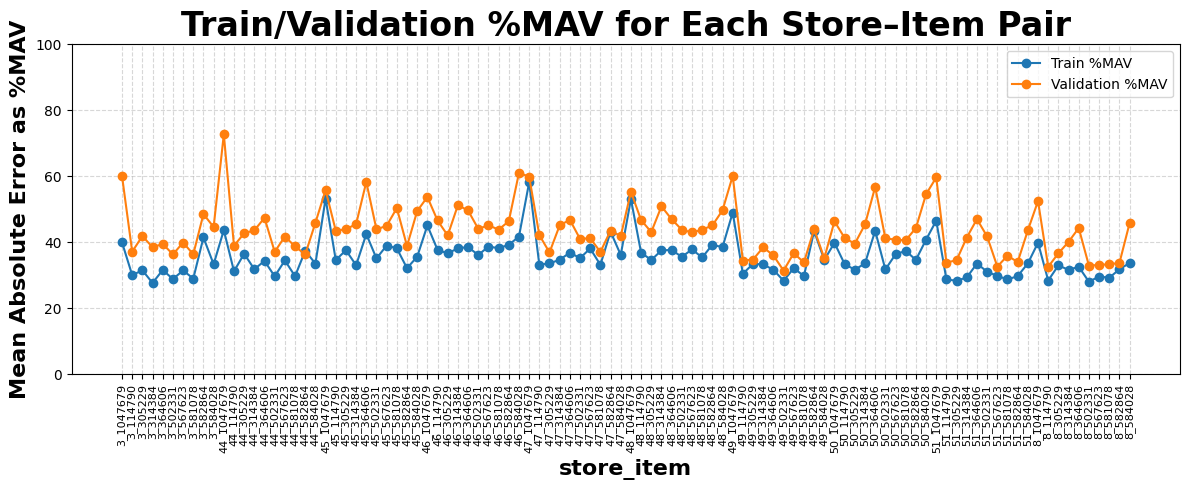

In [32]:
plot_final_percent_mav_per_sid(summary_df, title="Train/Validation %MAV for Each Store–Item Pair", 
                               fn="../output/figures/20250611_ResidualMLP_final_percent_mav_per_sid.tiff", y_lim=(0, 100))


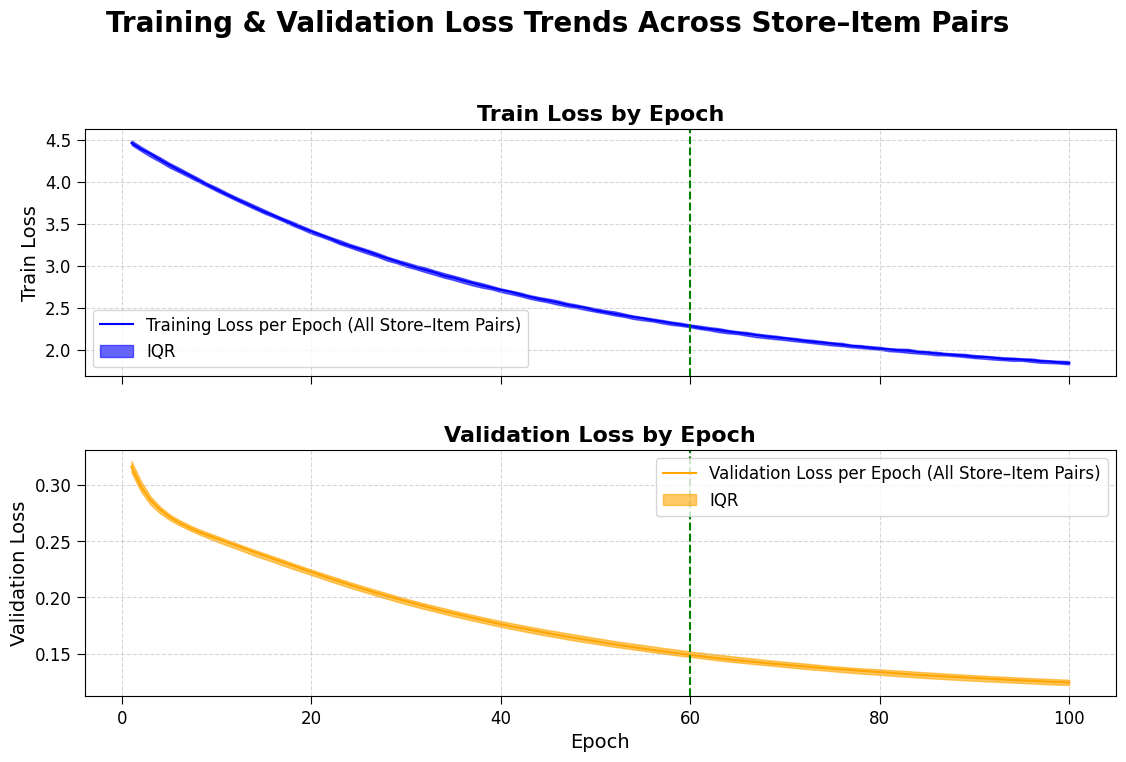

In [33]:
# plot_all_sids_losses(hist_df, 
#                      overall_title="Loss Curves for All Store Items",
# fn=f"../output/figures/all_sids_loss_curves_{today_str}.tiff")
plot_median_iqr_loss(hist_df, 
                     overall_title="Training & Validation Loss Trends Across Store–Item Pairs",
                     xvline=60,
fn=f"../output/figures/20250611_ResidualMLP_median_iqr_loss_curves_{today_str}.tiff")


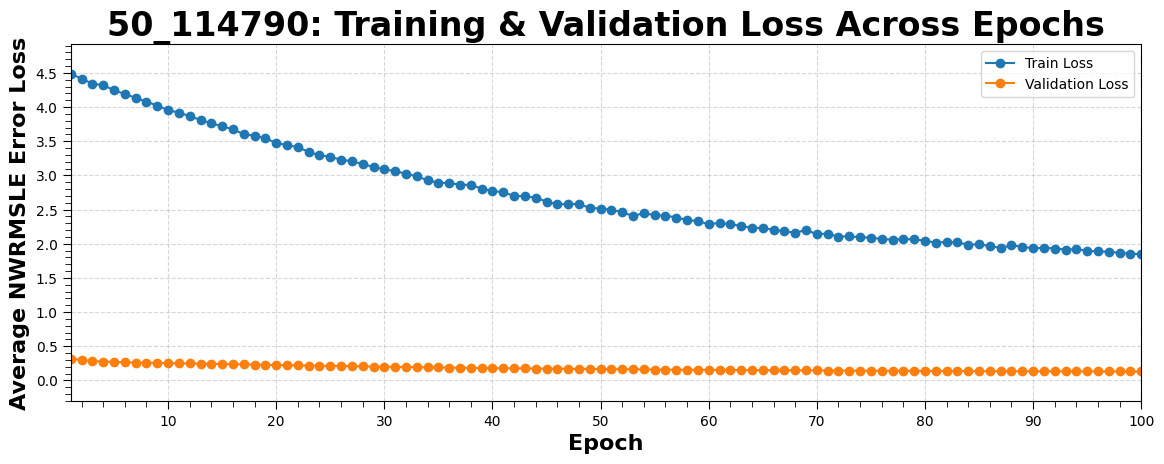

In [34]:
# to plot a single sid:
sid = "50_114790"
title = f"{sid}: Training & Validation Loss Across Epochs"
plot_loss_per_sid(hist_df, title = title,  
                  sid=sid, fn=f"../output/figures/20250611_ResidualMLP_loss_curves_{sid}.tiff",
                  train_col="train_loss", test_col="test_loss", y_label="Average NWRMSLE Error Loss")

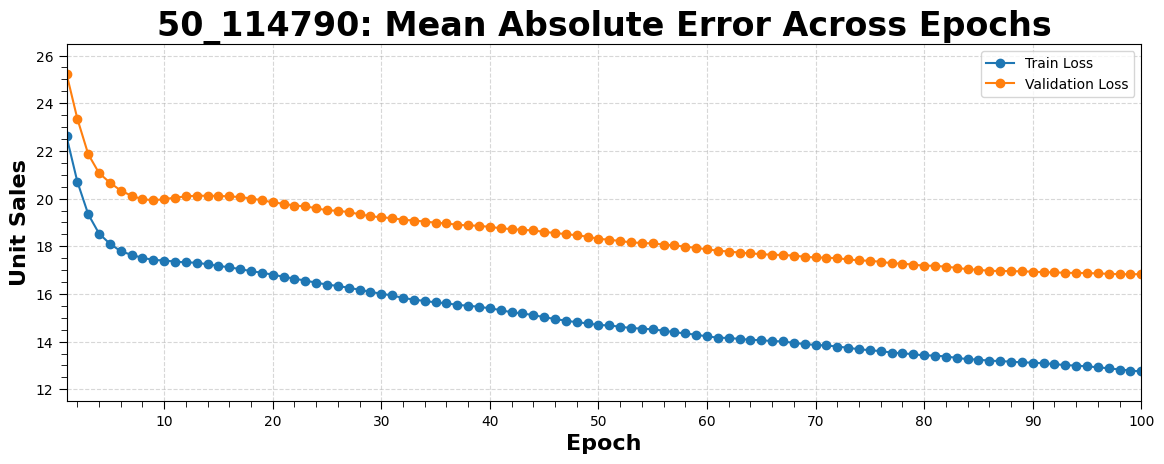

In [35]:
sid = "50_114790"
title = f"{sid}: Mean Absolute Error Across Epochs"
plot_loss_per_sid(hist_df, title=title, 
                  sid=sid, fn=f"../output/figures/20250611_ResidualMLP_loss_curves_mae_{sid}.tiff", 
                  train_col="train_mae", test_col="test_mae", y_label="Unit Sales")